In [ ]:
!sudo apt update
!sudo apt install libcairo2-dev \
    texlive texlive-latex-extra texlive-fonts-extra \
    texlive-latex-recommended texlive-science \
    tipa libpango1.0-dev \
    libsox-fmt-all \
    sox
!pip install manim
!pip install sox
!pip install IPython==8.21.0


In [ ]:
# Install required packages
!pip install openai pydantic manim-voiceover[transcribe]  "numpy<2.0"

In [ ]:
# API Keys
# Need OpenAI for voice/TTS and the LLM

import os
from google.colab import userdata

# Set API key from Colab secrets or ask for it
try:
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
    print("API key loaded from Colab secrets")
except:
    if "OPENAI_API_KEY" not in os.environ:
      os.environ["OPENAI_API_KEY"] = input("Enter your OpenAI API key: ")

print("OpenAI API key configured")

# KISS
## 1) Figure out the simplest control flow that accomplishes the task
## 2) Prompt engineering, structured outputs, how to have llms generate code in a format you want
## 3) Iterate on the control flow, orchestrate it in Langgraph, address why we even use langgraph instead of simply chaining api calls with if-then-else
## 4) Add RAG / Tools strategically within the flow, decide if MCP server would be helpful
## 5) Design Evals
## 6) Test, Iterate, Improve systematically
## 7) Refactor, version prompts, deploy


# We'll focus on 1 and 2 in this notebook

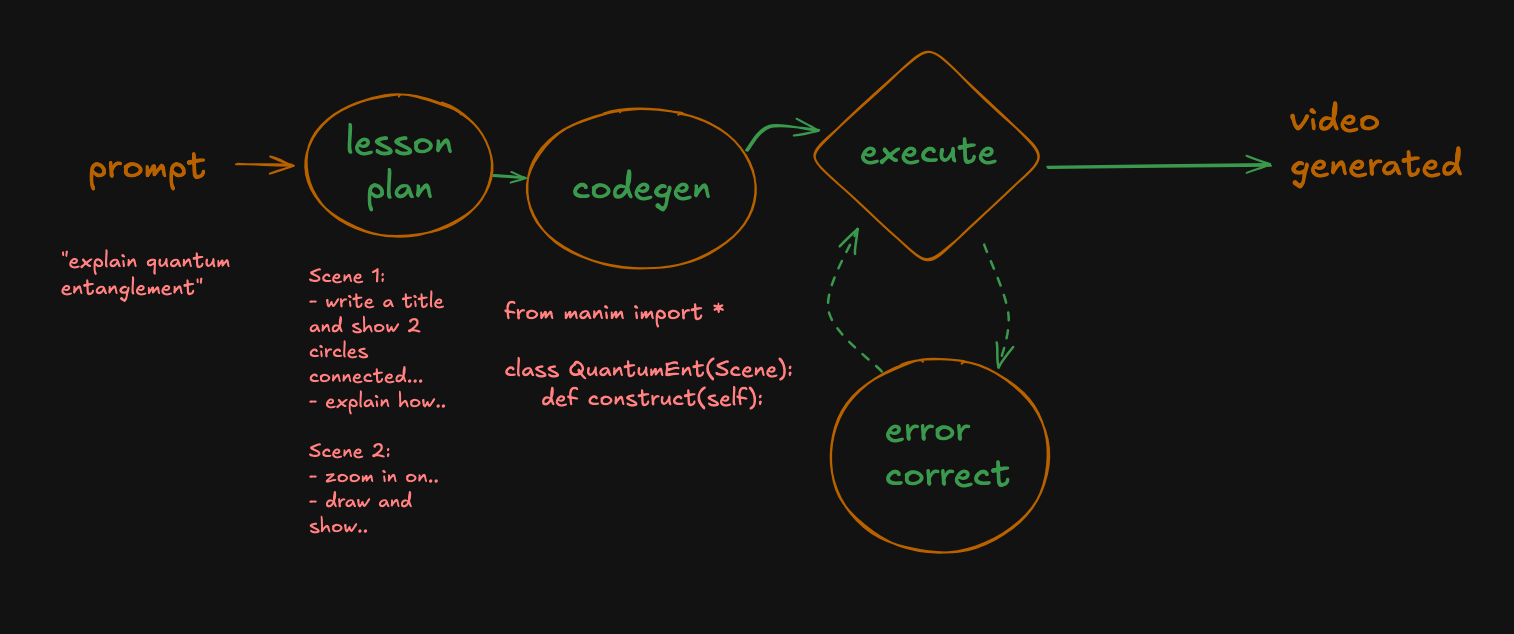

In [ ]:
from typing import  TypedDict, Optional, Dict, List, Any
from pydantic import  Field, BaseModel
from openai import OpenAI
import subprocess
import textwrap # for the printed text to be wrapped

MODEL = 'gpt-4o' # feel free to use 'o3-mini'

class ScenePlanResponse(BaseModel):
    plan: str = Field(description="Detailed plan for the animation")
    scene_class_name: str = Field(description="Name of the scene class")
    reasoning: Optional[str] = Field(None, description="Reasoning behind the plan")


def plan_scene(prompt:str) -> ScenePlanResponse:
    """Plan the scene for the animation using pydantic"""
    system_prompt = """
        You are a manim expert and an excellent teacher who can explain complex
        concepts in a clear and engaging way.
        You'll be working with a manim developer who will write a manim script
        to render a video that explains the concept.
        Your task is to plan the scenes for a 30-60 second video using objects
        and animations that are feasible to execute using Manim.
        Break it down into few scenes, use the following guidelines:

        INTRODUCTION AND EXPLANATION:
           - Introduce the concept with a clear title
           - Break down the concept into 2-3 key components
           - For each component, specify:
             * What visual elements to show (shapes, diagrams, etc.)
             * How they should move or transform
             * Exact narration text that syncs with the visuals

        PRACTICAL EXAMPLE:
           - Show a concrete, relatable example of the concept
           - Demonstrate cause and effect or the process in action
           - Include interactive elements if possible

        SUMMARY:
           - Recap the key points with visual reinforcement
           - Connect back to the introduction
           - End with asking the user a question that tests their understanding

        CRITICALLY IMPORTANT:
        For EACH scene:
        - Ensure that the visual elements do not overlap or go out of the frame
        - The scene measures 8 units in height and 14 units in width.
        The origin is in the center of the scene, which means that, for example,
        the upper left corner of the scene has coordinates [-7, 4, 0].
        - Ensure that objects are aligned properly (e.g., if creating a pendulum,
        the circle should be centered at the end of the line segment and move together with it as a cohesive unit)
        - Ensure that the scene is not too crowded
        - Ensure that the explanations are scientifically accurate and pedagogically effective
        - Specify the visual elements to include
        - Specify the exact narration text
        - Specify the transitions between scenes
        - When specifying colors, you MUST ONLY use standard Manim color constants like:
        BLUE, RED, GREEN, YELLOW, PURPLE, ORANGE, PINK, WHITE, BLACK, GRAY, GOLD, TEAL

    """
    user_prompt = f"Plan the scene for the following prompt: {prompt}"
    client = OpenAI()
    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        response_format=ScenePlanResponse
    )
    return response.choices[0].message.parsed



plan_scene_response = plan_scene("Explain quantum entanglement")
print("Scene Class Name:")
print(plan_scene_response.scene_class_name)
print("Plan:")
print("\n".join(textwrap.fill(line, width=80) for line in plan_scene_response.plan.split("\n")))
print("\nReasoning:")
print("\n".join(textwrap.fill(line, width=80) for line in plan_scene_response.reasoning.split("\n")))
# generated_code = generate_code(response.plan, response.scene_class_name)
# execute_manim_code(generated_code.code, response.scene_class_name)

In [ ]:
base_class_template = """
from manim import *
from manim_voiceover import VoiceoverScene
from manim_voiceover.services.openai import OpenAIService

class ManimVoiceoverBase(VoiceoverScene):
    "Base class for all generated Manim scenes with voiceover support.

    This class extends VoiceoverScene and provides additional utilities for
    managing mobjects within the frame, creating titles, and arranging objects.

    Attributes:
        FRAME_WIDTH (float): Width of the frame (default: 14)
        FRAME_HEIGHT (float): Height of the frame (default: 8)
    "

    # Frame boundary constants
    FRAME_WIDTH = 14
    FRAME_HEIGHT = 8

    def __init__(self, voice_model="nova"):
        "Initialize the ManimVoiceoverBase with voice model configuration.

        Args:
            voice_model (str, optional): OpenAI TTS voice model to use. Defaults to "nova".
        "
        super().__init__()
        # Setup voice service
        self.set_speech_service(
            OpenAIService(
                voice=voice_model,
                model="tts-1-hd"
            )
        )

    def create_title(self, text: str) -> VGroup:
        "Create title with auto-scaling to fit the frame.

        Creates a title text object and automatically scales it to fit within
        the frame boundaries if it's too large.

        Args:
            text (str): The title text to display

        Returns:
            VGroup: A Text mobject properly sized to fit as a title

        Example:
            >>> scene = ManimVoiceoverBase()
            >>> title = scene.create_title("My Animation Title")
            >>> scene.play(Write(title))
        "
        # Create title with auto-scaling to fit the frame
        title = Text(text, font_size=42).to_edge(UP, buff=0.5)
        if title.width > self.FRAME_WIDTH * 0.85:
            title.scale_to_fit_width(self.FRAME_WIDTH * 0.85)
        return title

    def fade_out_scene(self):
        "Fade out all mobjects except the background."
        self.play(*[FadeOut(mob) for mob in self.mobjects])

    def ensure_in_frame(self, mobject, padding=0.5):
        "Ensures a mobject stays within frame boundaries with padding."
        # Calculate boundaries with padding
        x_min = -self.FRAME_WIDTH/2 + padding
        x_max = self.FRAME_WIDTH/2 - padding
        y_min = -self.FRAME_HEIGHT/2 + padding
        y_max = self.FRAME_HEIGHT/2 - padding

        # Use proper Manim methods to get the bounding box
        left = mobject.get_left()[0]
        right = mobject.get_right()[0]
        bottom = mobject.get_bottom()[1]
        top = mobject.get_top()[1]

        # Adjust if needed
        if left < x_min:  # Left boundary
            mobject.shift(RIGHT * (x_min - left))
        if right > x_max:  # Right boundary
            mobject.shift(LEFT * (right - x_max))
        if bottom < y_min:  # Bottom boundary
            mobject.shift(UP * (y_min - bottom))
        if top > y_max:  # Top boundary
            mobject.shift(DOWN * (top - y_max))

        return mobject

    def scale_to_fit_frame(self, mobject, max_width_ratio=0.8, max_height_ratio=0.8):
        "Scales object to fit within frame if it's too large.

        Scales the mobject to fit within the specified ratio of the frame dimensions.

        Args:
            mobject: The mobject to scale
            max_width_ratio (float, optional): Maximum width as a ratio of frame width. Defaults to 0.8.
            max_height_ratio (float, optional): Maximum height as a ratio of frame height. Defaults to 0.8.

        Returns:
            The scaled mobject

        Example:
            >>> scene = ManimVoiceoverBase()
            >>> huge_square = Square(side_length=10)
            >>> scaled_square = scene.scale_to_fit_frame(huge_square)
            >>> scene.play(Create(scaled_square))
        "
        max_width = self.FRAME_WIDTH * max_width_ratio
        max_height = self.FRAME_HEIGHT * max_height_ratio

        if mobject.width > max_width:
            mobject.scale_to_fit_width(max_width)
        if mobject.height > max_height:
            mobject.scale_to_fit_height(max_height)

        return mobject

    def arrange_objects(self, objects, layout="horizontal", buff=0.5):
        "Arranges objects to prevent overlapping. Layouts: horizontal, vertical, grid"
        group = VGroup(*objects)

        if layout == "horizontal":
            group.arrange(RIGHT, buff=buff)
        elif layout == "vertical":
            group.arrange(DOWN, buff=buff)
        elif layout == "grid":
            # Calculate grid dimensions
            n = len(objects)
            cols = int(np.sqrt(n))
            rows = (n + cols - 1) // cols

            # Create grid arrangement
            grid = VGroup()
            for i in range(rows):
                row_group = VGroup()
                for j in range(cols):
                    idx = i * cols + j
                    if idx < n:
                        row_group.add(objects[idx])
                if len(row_group) > 0:
                    row_group.arrange(RIGHT, buff=buff)
                    grid.add(row_group)
            grid.arrange(DOWN, buff=buff)

            # Replace original group with grid arrangement
            for i, obj in enumerate(objects):
                if i < n:
                    objects[i].become(grid.submobjects[i // cols].submobjects[i % cols])

        # Ensure in frame and return
        return self.ensure_in_frame(group)
        """

In [ ]:
class ManimCodeResponse(BaseModel):
    code:str = Field(description="Complete valid Python code for the animation")
    explanation: Optional[str] = Field(None, description="Explanation of the code")
    error_fixes: Optional[List[str]] = Field(None, description="Error fixes if any")
    # i wanna point out that str is too loose and the result may not be valid python code
    # for proper validation use @field_validator
    # and perhaps retry logic in the generation step with the llm api
    # but modern llms are pretty good at sticking to code

    # @field_validator("code")
    # def validate_code(cls, v):
    #     try:
    #         ast.parse(v)
    #     except Exception as e:
    #         raise ValueError("Invalid Python code")

def generate_code(plan:str, scene_class_name:str) -> ManimCodeResponse:
    """Generate a manim code from the plan"""
    system_prompt = f"""
    You are an expert Manim developer.
    Create complete, runnable Python code for a class that inherits from ManimVoiceoverBase.
    Use the CODE TEMPLATE provided to generate the code and do not modify the ManimVoiceoverBase class.

    REQUIREMENTS:
    - Structure code into logical scene methods called sequentially in construct()
    - Wrap all animations in voiceover blocks using tracker.duration for timing,
    and ensure that run_time for each self.play() is divided such that it adds up to tracker.duration.
    For example:
    ```python
    with self.voiceover(text="Today we will learn about derivatives") as tracker:
        self.play(Write(title), run_time=tracker.duration * 0.5)
        self.play(Create(road), run_time=tracker.duration * 0.2)
        self.play(FadeIn(car), run_time=tracker.duration * 0.3)
    ```

    - Use self.fade_out_scene() to clean up after each section
    - Must use only standard Manim color constants like:
        BLUE, RED, GREEN, YELLOW, PURPLE, ORANGE, PINK, WHITE, BLACK, GRAY, GOLD, TEAL
    - Use MathTex for mathematical expressions, never Tex

    RESTRICTIONS:
    - Never create background elements
    - Never modify camera background or frame
    - For zoom effects, scale objects directly
    - For transitions, use transforms between objects

    BASE CLASS METHODS:
    - create_title(text): creates properly sized titles
    - fade_out_scene(): fades out all objects


    FRAME MANAGEMENT REQUIREMENTS:
    - Always use the base class utilities to ensure objects stay within the frame:
    * self.ensure_in_frame(mobject): Adjusts object position to stay within frame
    * self.scale_to_fit_frame(mobject): Scales objects that are too large
    * self.arrange_objects([objects], layout="horizontal"/"vertical"/"grid"): Prevents overlapping
    - For complex diagrams, call self.scale_to_fit_frame() after creation
    - For text elements, use appropriate font sizes (24-36 for body text, 42 for titles)
    - For multiple objects, ALWAYS use self.arrange_objects() to position them
    - For precise positioning, remember the frame is 14 units wide and 8 units high
    - For debugging, use self.debug_frame() to visualize frame boundaries

    Example usage:
    ```python
    # Create objects
    formula = MathTex(r"F = ma").scale(1.5)
    formula = self.scale_to_fit_frame(formula)

    # For multiple objects
    objects = [Circle(), Square(), Triangle()]
    self.arrange_objects(objects, layout="horizontal")

    # For text that might be too long
    explanation = Text("Long explanation text...", font_size=28)
    explanation = self.ensure_in_frame(explanation)

    CODE TEMPLATE:
    ```python
        {base_class_template}

        class {scene_class_name}(ManimVoiceoverBase):
            def construct(self):
                # Call each scene method in sequence
                self.intro_and_explanation()
                self.practical_example()
                self.summarize()

            def intro_and_explanation(self):
                "
                Introduces the concept and explains it.
                "
                # Create a title
                title = self.create_title("Your Title Here")

                # Create a visual representation of the concept
                # Explain the concept with requisite visuals
                # For example, if the concept is about a car moving on a road, you can create a road and a car
                # and animate the car moving on the road.
                road = ParametricFunction(
                    lambda t: np.array([2*t - 4, 0.5 * np.sin(t * PI) - 1, 0]),
                    t_min=0, t_max=4,
                    color=WHITE
                )

                # Create a 'car' represented by a small dot
                car = Dot(color=GREEN).move_to(road.point_from_proportion(0))

                with self.voiceover(text="Your narration here") as tracker:
                    self.play(Write(title), run_time=tracker.duration * 0.2)
                    self.play(Create(road), run_time=tracker.duration * 0.3)
                    self.play(MoveAlongPath(car, road), rate_func=linear, run_time=tracker.duration * 0.5)

                # Clean up the scene when done
                self.fade_out_scene()

            def show_example(self):
                # Your example here
                # Clean up the scene when done
                self.fade_out_scene()
                pass

            def summarize(self):
                # Your recap and question here
                pass
        ```
    """
    user_prompt = f"Generate a manim code from the following plan: {plan}"
    client = OpenAI()
    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        response_format=ManimCodeResponse
    )
    return response.choices[0].message.parsed



In [ ]:
generated_code = generate_code(plan_scene_response.plan, plan_scene_response.scene_class_name)


In [ ]:
print(generated_code.code)


In [ ]:
import time
import numpy as np
import os
import time
import glob
from IPython.display import Video, display, clear_output
import subprocess
class ManimExecutionResponse(BaseModel):
    output: str = Field(description="Output of the execution")
    error: Optional[str] = Field(None, description="Error message")


def execute_manim_code(code: str, scene_class_name: str) -> ManimExecutionResponse:
    # Save code to file
    file_path = f"{scene_class_name}.py"
    with open(file_path, "w") as f:
        f.write(code)

    print(f"Saved code to: {os.path.abspath(file_path)}")
    print(f"Starting Manim code execution...")

    # Build command
    cmd = [
        "python", "-m", "manim",
        "-pql",  # preview, low quality
        file_path,
        scene_class_name
    ]

    # Execute the command
    start_time = time.time()
    result = subprocess.run(cmd, capture_output=True, text=True)
    duration = time.time() - start_time

    # Process result
    success = result.returncode == 0

    if success:
        print(f" Animation completed successfully! (took {duration:.1f} seconds)")

        # Find the generated video file
        video_files = glob.glob(f"media/videos/{scene_class_name}/480p15/*.mp4", recursive=True)
        if video_files:
            # Get the most recently created file
            video_path = max(video_files, key=os.path.getctime)
            print(f" Video saved to: {os.path.abspath(video_path)}")

            # Display the video in the notebook
            print("Playing animation:")
            display(Video(video_path, embed=True, width=800))
        else:
            print("Animation ran but no video file was found.")
    else:
        print("Animation failed to render.")
        print("\n--- Error Details ---")
        error_msg = result.stderr
        if len(error_msg) > 10000:  # If error is too long, show beginning and end
            print(error_msg[:5000])
            print("...")
            print(error_msg[-5000:])
        else:
            print(error_msg)

    return ManimExecutionResponse(output=result.stdout, error=result.stderr)

In [ ]:
result = execute_manim_code(generated_code.code, plan_scene_response.scene_class_name)

In [ ]:
class ManimErrorCorrectionResponse(BaseModel):
    fixed_code: str = Field(description="The corrected Manim code that should resolve the errors")
    explanation: str = Field(description="Explanation of what was fixed and why")
    changes_made: List[str] = Field(description="List of specific changes made to fix the code")

def correct_manim_errors(code: str,error_message: str) -> ManimErrorCorrectionResponse:
    """
    Analyze Manim errors and generate fixed code.

    Args:
        code: Original Manim code that produced errors
        error_message: Error output from the Manim execution
        scene_class_name: Name of the scene class

    Returns:
        ManimErrorCorrectionResponse with fixed code and explanation
    """
    system_prompt = """
    You are an expert Manim developer and debugger. Your task is to fix errors in Manim code.

    ANALYZE the error message carefully to identify the root cause of the problem.
    EXAMINE the code to find where the error occurs.
    FIX the issue with the minimal necessary changes.

    Common Manim errors and solutions:
    1. 'AttributeError: object has no attribute X' - Check if you're using the correct method or property for that object type
    2. 'ValueError: No coordinates specified' - Ensure all mobjects have positions when created or moved
    3. 'ImportError: Cannot import name X' - Verify you're using the correct import from the right module
    4. 'TypeError: X() got an unexpected keyword argument Y' - Check parameter names and types
    5. 'Animation X: 0%' followed by crash - Look for errors in animation setup or objects being animated

    When fixing:
    - Preserve the overall structure and behavior of the animation
    - Ensure all objects are properly created and positioned
    - Check that all animations have proper timing and sequencing
    - Verify that voiceover sections have proper timing allocations
    - Maintain consistent naming and style throughout the code

    Your response must include:
    1. The complete fixed code
    2. A clear explanation of what was wrong and how you fixed it
    3. A list of specific changes you made
    """

    user_prompt = f"""
    Please fix the errors in this Manim code.


    CODE WITH ERRORS:
    ```python
    {code}
    ```

    ERROR MESSAGE:
    ```
    {error_message}
    ```

    Please provide a complete fixed version of the code, along with an explanation of what went wrong and how you fixed it.
    """

    client = OpenAI()
    response = client.beta.chat.completions.parse(
        model="o3-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        response_format=ManimErrorCorrectionResponse
    )
    return response.choices[0].message.parsed

In [ ]:
# Run the error correction function
correction_result = correct_manim_errors(
    code=generated_code.code,
    error_message=result.error,
)

# Print the explanation of what was fixed
print(" Error analysis:")
print(correction_result.explanation)
print("\n Changes made:")
for change in correction_result.changes_made:
    print(f"- {change}")


In [ ]:
print(correction_result.fixed_code)

In [ ]:
result_corrected = execute_manim_code(correction_result.fixed_code, plan_scene_response.scene_class_name)

# If it still doesn't work, run the code through error_correction node again!

In [ ]:
# print(result_corrected.error)

# # Run the error correction function again
# correction_result_2 = correct_manim_errors(
#     code=correction_result.fixed_code,
#     error_message=result_corrected.error,
# )

# # Print the explanation of what was fixed
# print(" Error analysis:")
# print(correction_result_2.explanation)
# print("\n Changes made:")
# for change in correction_result_2.changes_made:
#     print(f"- {change}")

# result_corrected_2 = execute_manim_code(correction_result_2.fixed_code, plan_scene_response.scene_class_name)


In [ ]:
def generate_and_execute_with_correction(prompt: str, max_correction_attempts: int = 3) -> Dict:
    """
    Complete workflow to generate, execute, and fix Manim animations.

    Args:
        prompt: User's description of the animation they want
        max_correction_attempts: Maximum number of error correction attempts

    Returns:
        Dictionary with final results including code, execution result, and video path
    """
    # Step 1: Plan the scene
    storyboard_response = plan_scene(prompt)
    scene_class_name = storyboard_response.scene_class_name
    print(f" Scene planning complete: {scene_class_name}")

    # Step 2: Generate the code
    generated_code = generate_code(storyboard_response.plan, scene_class_name)
    current_code = generated_code.code
    print(" Initial code generation complete")

    # Step 3: Execute with correction loop
    for attempt in range(max_correction_attempts + 1):
        if attempt > 0:
            print(f"\n🔄 Correction attempt {attempt}/{max_correction_attempts}...")

        # Execute current code
        result = execute_manim_code(current_code, scene_class_name)

        # Check if execution succeeded
        if not result.error or "Animation completed successfully" in result.output:
            print(" Animation executed successfully!")
            break

        # If we've reached max attempts, exit
        if attempt >= max_correction_attempts:
            print(f" Failed to fix errors after {max_correction_attempts} attempts.")
            break

        # Try to fix the errors
        print("Errors detected, attempting to fix...")
        correction = correct_manim_errors(current_code, result.error)

        print(f"Applied fixes: {', '.join(correction.changes_made)}")

        # Update the code for next attempt
        current_code = correction.fixed_code

    # Return results
    return {
        "scene_class_name": scene_class_name,
        "final_code": current_code,
        "plan": storyboard_response.plan,
        "execution_result": result,
        "correction_attempts": attempt
    }

In [ ]:
# Run the entire workflow with automatic error correction
result = generate_and_execute_with_correction("Explain derivatives")

# Access components of the result
final_code = result["final_code"]
scene_class_name = result["scene_class_name"]
correction_attempts = result["correction_attempts"]

print(f"Animation created with {correction_attempts} correction attempts")